# Main goal: check if small cells/blobs are typical for each structure or not

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys, os, time

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'cells'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'annotation'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'learning'))
import matplotlib.pyplot as plt
import numpy as np
import scipy
import skimage
from skimage.filters import threshold_otsu
from scipy.ndimage.morphology import distance_transform_edt
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.transform import resize
from skimage.color import rgb2hsv
from scipy import ndimage as ndi
import pandas
from scipy.signal import argrelmax
from scipy.stats import linregress

from annotation_utilities import *
from registration_utilities import *
from learning_utilities import *
from data_manager import *
from utilities2015 import *
from cell_utilities import *
from metadata import *
from distributed_utilities import download_from_s3

Setting environment for AWS compute node


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


In [2]:
save_folder_path = '/shared/MouseBrainAtlasXiang/XJ/Output/Bolb_detection_with_predetected_cells/'
from xj_utilities import *
fun_create_folder(save_folder_path=save_folder_path)

Folder already exists: /shared/MouseBrainAtlasXiang/XJ/Output/Bolb_detection_with_predetected_cells/

In [3]:
def fun_radius_bbox(min_0, min_1, max_0, max_1):
    """
    radisu_bbox(min_0, min_1, max_0, max_1), correspond to the order of regionprops.bbox tuple
    """
    radius = 0.5 * ((max_1 - min_1)**2 + (max_0 - min_0)**2) ** 0.5
    return radius

def fun_crop_images(image, min_0, min_1, max_0, max_1, margin=0,im0max=10000,im1max=10000):
    min_0 = max(min_0-margin,0)
    max_0 = max_0+margin
    if max_0 > im0max:
        raise ValueError('Warning: The default limit is used. Please specify the image size')
        max_0 = im0max
    min_1 = max(min_1-margin,0)
    max_1 = max_1+margin
    if max_1 > im1max:
        raise ValueError('Warning: The default limit is used. Please specify the image size')
        max_1 = im1maxV
    crop_image = image[min_0:max_0, min_1:max_1].copy()
#     print((min_0, min_1, max_0, max_1))
    return crop_image

def fun_scan_range(cloc,radius,im1max=10000,im0max=10000,o_form='1D'):
    cloc = np.array(cloc);
    min_0 = int(max(np.round(cloc - radius)[0],0))
    min_1 = int(max(np.round(cloc - radius)[1],0))
    max_0 = int(min(np.round(cloc + radius)[0],im0max))
    max_1 = int(min(np.round(cloc + radius)[1],im1max))
    local_cloc = (int(cloc[0] - min_0), int(cloc[1] - min_1))
    if o_form == '1D':
        return (min_0, min_1, max_0, max_1), local_cloc
    elif o_form == '2D':
        return np.array([[min_0,min_1],[min_0,max_1],[max_0,max_1],[max_0,min_1]]), local_cloc
    
def fun_mxmx2mmxx(min_0,max_0,min_1,max_1):
    return (min_0,min_1,max_0,max_1)

def fun_mmxx2mxmx(min_0,min_1,max_0,max_1):
    return (min_0,max_0,min_1,max_1)

def fun_local_distance(blob_loc_tuple, local_cloc_tuple):
    r = ((blob_loc_tuple[0] - local_cloc_tuple[0]) ** 2 + ((blob_loc_tuple[1] - local_cloc_tuple[1]) ** 2) ) ** 0.5
    return r

def fun_similarity(oriIprops,nextIprops,distance_type='euclid'):
    similarity = [];
    num_blob = len(nextIprops);
    pi = 3.1415926
    for i in range(num_blob):
        if distance_type == 'euclid':
            difference = abs(oriIprops - nextIprops[i])/abs(float(max(oriIprops, nextIprops[i])) + 0.000000000001)
        elif distance_type == 'area':
            difference = abs(oriIprops - nextIprops[i])/(float(max(oriIprops, nextIprops[i])) + 0.000000000001)
        elif distance_type == 'eccentricity':
            difference = abs(oriIprops - nextIprops[i])/(float(max(oriIprops, nextIprops[i])) + 0.000000000001)
        elif distance_type == 'moments_hu':
            difference = np.abs(np.abs(oriIprops) - np.abs(np.array(nextIprops[i],dtype=np.float)))/np.abs( np.max(np.abs(np.vstack((oriIprops,nextIprops[i]))),axis=0) + 10**(-16)) 
        
        elif distance_type == 'equivalent_diameter':
            difference = abs(oriIprops - nextIprops[i])/(float(max(oriIprops, nextIprops[i])) + 0.000000000001)
        elif distance_type == 'orientation':
            diff_angle = abs(oriIprops - nextIprops[i])
            diff_angle = min(diff_angle, pi - diff_angle )
            similarity.append(np.cos(diff_angle))
            continue
        elif distance_type == 'angular':
            diff_angle = abs(oriIprops - nextIprops[i])
            diff_angle = min(diff_angle, pi - diff_angle )
            difference = np.cos(diff_angle) 
        similarity.append( 1 - difference) 
    return similarity

def fun_reconstruct_labeled_image(cell_global_coord,oriImL0, oriImL1, crop_range=None, op_clear_border=True,op_relabel=True):
    """ cell_global_coord = list of coordinate of the global index position of all the pixel in each blob
        oriImL1, oriImL0 = metadata_cache['image_shape][stack]
        crop_range = (min0, max0, min1, max1)
        return: labeled_image, blob_prop_List
    """
    cell_numbers = len(cell_global_coord);
    tempLabeledImage = np.zeros([oriImL0,oriImL1],dtype=np.int32)
    
    for tempBlobIndex in range(cell_numbers):
        tempBlobCoor = cell_global_coord[tempBlobIndex]
        tempLabeledImage[tempBlobCoor[:,0],tempBlobCoor[:,1]] = tempBlobIndex + 1
    if crop_range is not None:
        crop_0_min = crop_range[0]
        crop_0_max = crop_range[1]
        crop_1_min = crop_range[2]
        crop_1_max = crop_range[3]
        tempLabeledImage = tempLabeledImage[crop_0_min:crop_0_max, crop_1_min:crop_1_max]
    if op_clear_border:
        tempLabeledImage = skimage.segmentation.clear_border(tempLabeledImage)
        
    if op_relabel:
        im_label_ori = tempLabeledImage
        tempLabeledImage = skimage.measure.label(tempLabeledImage > 0)
        im_blob_prop = skimage.measure.regionprops(tempLabeledImage)
        return tempLabeledImage, im_blob_prop, im_label_ori
    else:
        im_blob_prop = skimage.measure.regionprops(tempLabeledImage)
        return tempLabeledImage, im_blob_prop

In [4]:
stack = 'MD589'
pixel_size = 0.46
pixel_area = pixel_size ** 2
patch_size = 448
# patch_half_size = patch_size / 2
# stride = 112
# Crop images
# 
# crop_0_min = 9000
# crop_0_max = 10500
# crop_1_min = 3000
# crop_1_max = 4500

# Brain stem
# crop_0_min = 8000
# crop_0_max = 11000
# crop_1_min = 8000
# crop_1_max = 12000

# Inside
# crop_x_min = 4000
# crop_x_max = 6000
# crop_y_min = 2400
# crop_y_max = 4400

# Whole
crop_0_min = 0
crop_1_min = 0
crop_1_max, crop_0_max = metadata_cache['image_shape'][stack]
# _, _, crop_1_max, crop_0_max = get_default_gridspec(stack=stack, patch_size=patch_size, stride=stride)
im0max = crop_0_max - crop_0_min
im1max = crop_1_max - crop_1_min
crop_image_width = crop_1_max - crop_1_min
crop_image_height = crop_0_max - crop_0_min

# patch_center_pixel_location = grid_parameters_to_sample_locations((patch_size, stride, crop_image_width, crop_image_height ))
# patch_ul = patch_center_pixel_location + ( - patch_half_size, - patch_half_size )
# patch_ur = patch_center_pixel_location + ( - patch_half_size,   patch_half_size )
# patch_dl = patch_center_pixel_location + (   patch_half_size, - patch_half_size )
# patch_dr = patch_center_pixel_location + (   patch_half_size,   patch_half_size )
# patch_contour = np.array(zip(patch_ul, patch_ur, patch_dr, patch_dl))

# Options
option_rescale_grayscale = True
option_THimage_save = True;
option_save_image_extension = '.png'

# Process images
option_label_connectivity = 4;

# Load images

In [5]:
# Set examine section number range and download from S3 if not available
img_filename = []
cell_orientations = []
cell_centroids = []
cell_numbers = []
cell_contour = []
cell_global_coord = []
secIndexList = range(200, 201)

for tempIndex1 in range(len(secIndexList)):
    img_filename.append(DataManager.get_image_filepath(stack=stack, section=secIndexList[tempIndex1], resol='lossless', version='cropped'))

    cell_centroids.append(load_cell_data('centroid',stack=stack,sec=secIndexList[tempIndex1]))
    cell_numbers.append(cell_centroids[tempIndex1].shape[0])
    cell_global_coord.append(load_cell_data('coords', stack=stack, sec=secIndexList[tempIndex1]))
    if os.path.isfile(img_filename[tempIndex1]):
        sys.stderr.write('Image file is already available. \n')
        continue
    else:
        try:
            download_from_s3(img_filename[tempIndex1])
        except:
            sys.stderr.write('Download fail. Skip this file...\n')
            continue

Image file is already available. 


In [8]:
img_filename

['/shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-N36-2015.07.30-18.28.52_MD589_2_0107_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif']

In [7]:
option_rescale_grayscale = True
option_inverse_color = False
# secIndex = 0

n_images = len(img_filename)
im_cropped = []
im_rescale = []
for imIndex in range(n_images):
    im_cropped.append(img_as_ubyte(rgb2gray(imread(img_filename[imIndex])[crop_0_min:crop_0_max, crop_1_min:crop_1_max])))
    if option_rescale_grayscale:
        im_rescale.append(fun_rescale_grayscale_image(im_cropped[imIndex],invcol=option_inverse_color))

/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [55]:
display_image(im_rescale[secIdx])

/shared/MouseBrainAtlasXiang/XJ/tmp.jpg

## Load annotated structures

In [9]:
contour_df, _ = DataManager.load_annotation_v3(stack=stack);
contour_df = convert_annotation_v3_original_to_aligned_cropped(contour_df, stack);
contour_df

'No object named structures in the file'


Annotation has no structures.


,creator,downsample,edits,flags,id,label_position,name,orientation,parent_structure,section,side,side_manually_assigned,time_created,vertices,filename
10001747656938,yuncong,1,"[{u'username': u'yuncong', u'timestamp': u'091...",1,10001747656938,"[7205.9591125, 7114.27067383]",VCA,sagittal,[],352,R,False,09152016033619,"[[7629.99467965, 7574.90397532], [7485.9870003...",MD589-N66-2015.07.30-20.35.16_MD589_3_0198
100179733918340,yuncong,1,"[{u'username': u'yuncong', u'timestamp': u'091...",1,100179733918340,"[10809.5686275, 11042.0392157]",IO,sagittal,[],211,L,False,09152016013448,"[[12296.0, 11384.0], [12136.0, 11384.0], [1197...",MD589-IHC39-2015.07.30-23.58.27_MD589_1_0115
100436364177927,yuncong,1,"[{u'username': u'yuncong', u'timestamp': u'091...",1,100436364177927,"[8096.73940575, 9954.67974641]",7N,sagittal,[],306,R,False,09152016032103,"[[8199.36065389, 10414.6304388], [8039.3606724...",MD589-N59-2015.07.30-20.07.00_MD589_1_0175
100739086246252,yuncong,1,"[{u'username': u'yuncong', u'timestamp': u'091...",0,100739086246252,"[7310.23042322, 7599.59633289]",VCA,sagittal,[],362,R,False,09122016232306,"[[6715.67992089, 7672.97261163], [6513.8375529...",MD589-N68-2015.07.30-20.43.04_MD589_2_0203
100789576647628,yuncong,1,"[{u'username': u'yuncong', u'timestamp': u'091...",0,100789576647628,"[7254.36247676, 8046.09668793]",VCA,sagittal,[],105,L,False,09152016004705,"[[7472.93079852, 9225.3972832], [7234.92441371...",MD589-IHC18-2015.07.30-22.27.59_MD589_3_0054
100920121924561,yuncong,1,"[{u'username': u'yuncong', u'timestamp': u'091...",1,100920121924561,"[6768.47011567, 5329.54033109]",LPB,sagittal,[],291,R,False,09152016025057,"[[6301.18675331, 5895.54293764], [6141.1867718...",MD589-IHC56-2015.07.31-01.13.31_MD589_2_0167
101502220498012,yuncong,1,"[{u'username': u'yuncong', u'timestamp': u'091...",1,101502220498012,"[11558.6287406, 8016.80382721]",AP,sagittal,[],228,S,False,09152016020431,"[[11942.3481968, 8308.82981826], [11782.348215...",MD589-N43-2015.07.30-18.56.33_MD589_2_0128
101511503885989,yuncong,1,"[{u'username': u'yuncong', u'timestamp': u'091...",0,101511503885989,"[5367.44413945, 2965.34815598]",SC,sagittal,[],145,S,False,09122016161137,"[[4123.60652769, 2691.92622354], [4314.4160263...",MD589-IHC25-2015.07.30-22.57.23_MD589_2_0074
101528011891079,yuncong,1,"[{u'username': u'yuncong', u'timestamp': u'091...",1,101528011891079,"[10192.6557377, 9054.16393443]",Sp5I,sagittal,[],140,L,False,09152016004720,"[[10656.0, 10104.0], [10496.0, 10104.0], [1033...",MD589-N24-2015.07.30-17.35.51_MD589_3_0072
101709650119044,yuncong,1,"[{u'username': u'yuncong', u'timestamp': u'091...",0,101709650119044,"[3111.5398317, 7186.70030458]",SNR,sagittal,[],290,R,False,09122016214704,"[[2289.74413818, 7958.97480368], [2164.2901186...",MD589-N56-2015.07.30-19.54.42_MD589_2_0167


## Reconstruct labeled images from detected cell dataset

In [11]:
oriImL1,oriImL0 = metadata_cache['image_shape'][stack]

option_crop = True
option_clear_border = True
option_relabel = True
im_blob_prop = {}
im_label_ori = []
im_label = []
im_BW = []
crop_range = (crop_0_min,crop_0_max,crop_1_min,crop_1_max)
for tempSecIndex in range(n_images):
    temp_im_label, temp_im_blob_prop, _ = fun_reconstruct_labeled_image(cell_global_coord[tempSecIndex],crop_range= crop_range, 
                                                                    oriImL0=oriImL0,oriImL1=oriImL1)
    im_label.append(temp_im_label)
    im_BW.append(temp_im_label>0)
    im_blob_prop[secIndexList[tempSecIndex]]  = temp_im_blob_prop
    
n_blobs = map(len, im_blob_prop.values())

In [75]:
secIdx = 0
sec = secIndexList[secIdx]
cell_area_0 = np.array([im_blob_prop[sec][blobID]['area'] for blobID in range(n_blobs[secIdx])],dtype=np.int32)

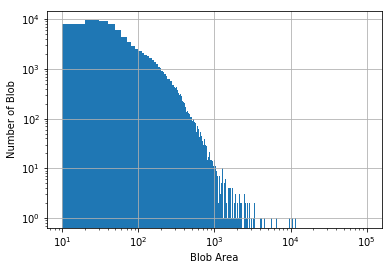

In [81]:
plt.hist(cell_area_0,range=(0,100000),bins=10000);
plt.yscale('log', nonposy='clip')
plt.xscale('log')
plt.xlabel('Blob Area')
plt.ylabel('Number of Blob')
plt.grid()

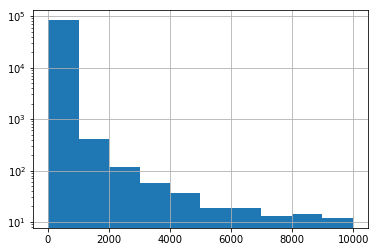

In [80]:
# Delete extremely large bolbs:
cell_area_cutoff = 10000
cell_area = cell_area_0[cell_area_0<cell_area_cutoff]
plt.hist(cell_area);
plt.yscale('log', nonposy='clip')
plt.grid()

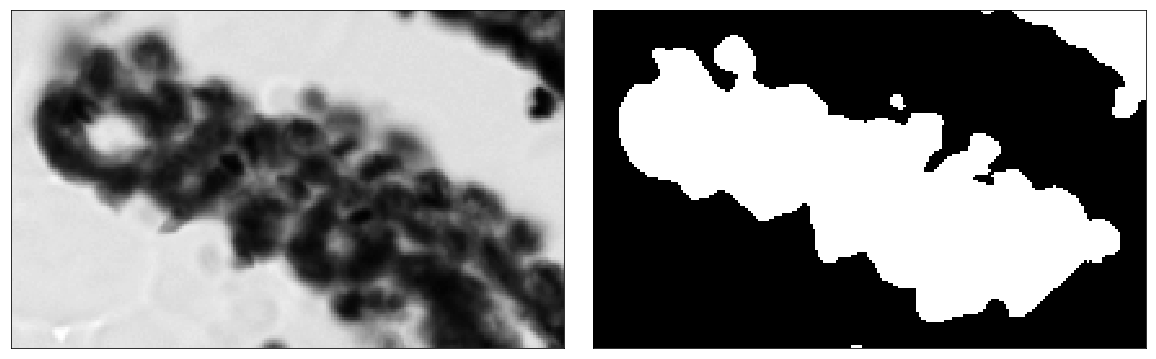

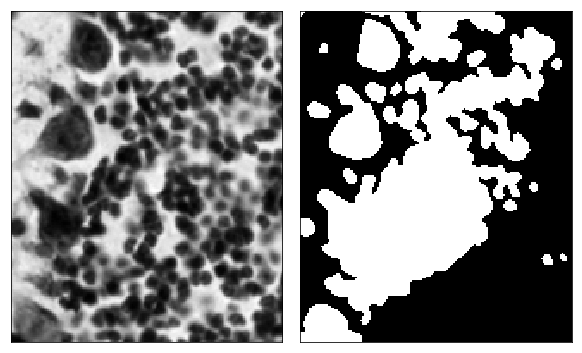

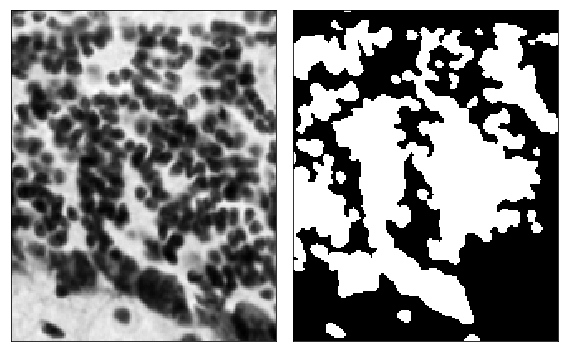

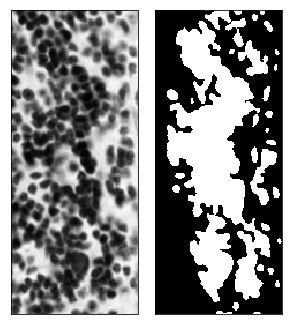

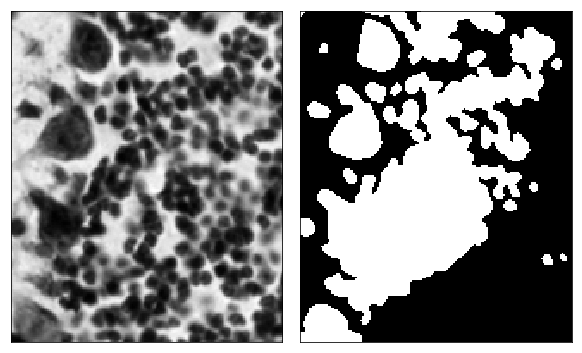

In [47]:
# Visualize large blobs (size between 9000 and 10000 pixels)
# Conclusion: blob size between 9000 and 10000 piexls are definitely not single cells
cell_idx_10000 = np.where(np.logical_and(cell_area_0>9000, cell_area_0<=10000))[0]
margin = 10
for blobID in np.random.choice(cell_idx_10000,5):
    display_images_in_grids([fun_crop_images(im_cropped[secIdx],*im_blob_prop[sec][blobID]['bbox'],margin=margin, im0max=im0max, im1max=im1max),
                            fun_crop_images(im_BW[secIdx],*im_blob_prop[sec][blobID]['bbox'],margin=margin, im0max=im0max, im1max=im1max)]
                            ,nc=2, cmap=plt.cm.gray)

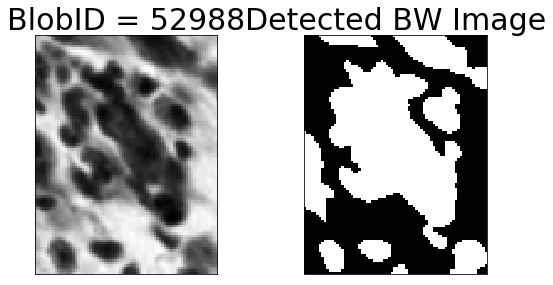

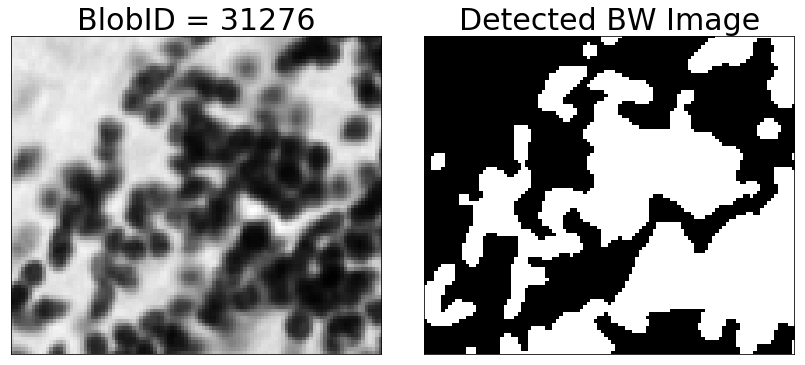

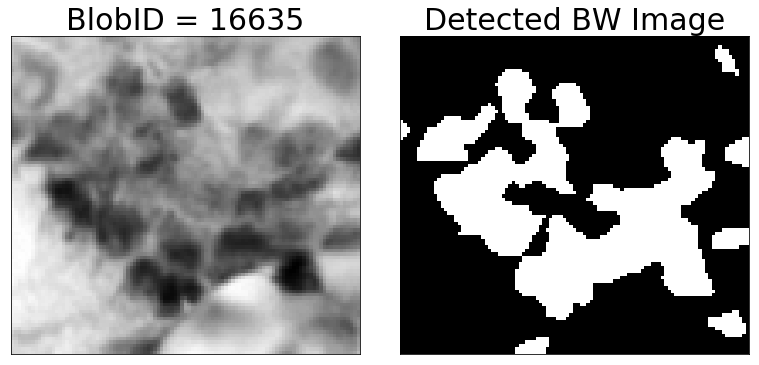

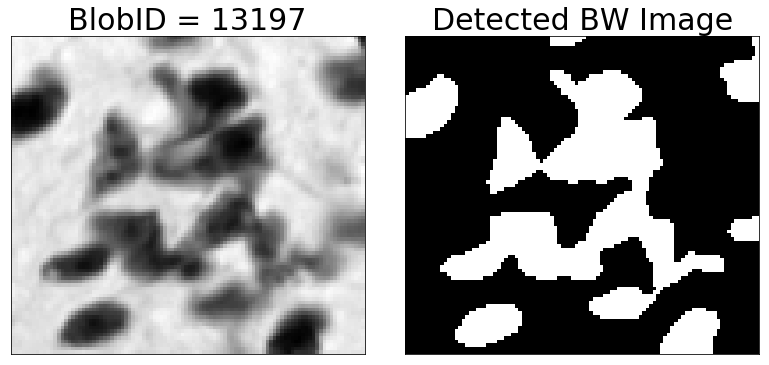

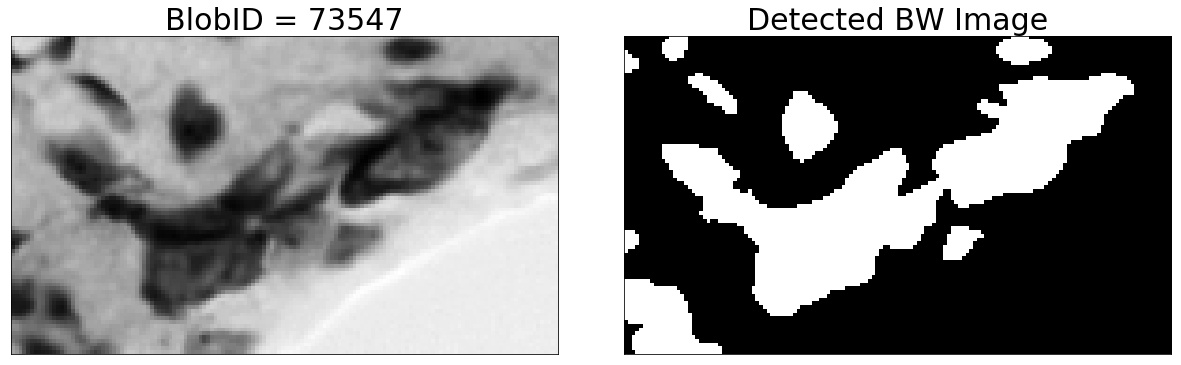

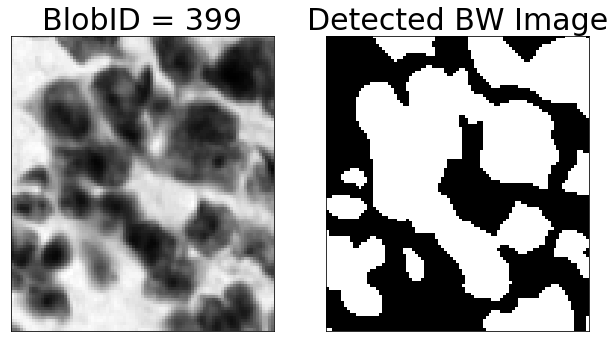

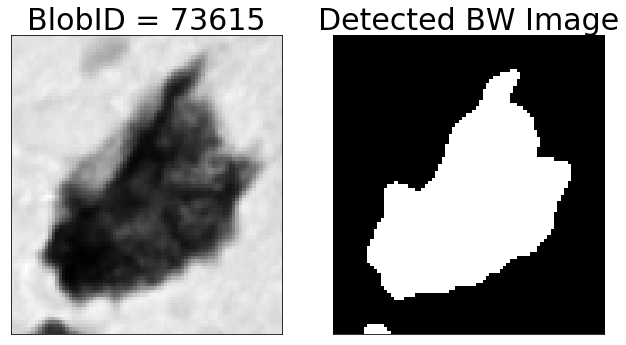

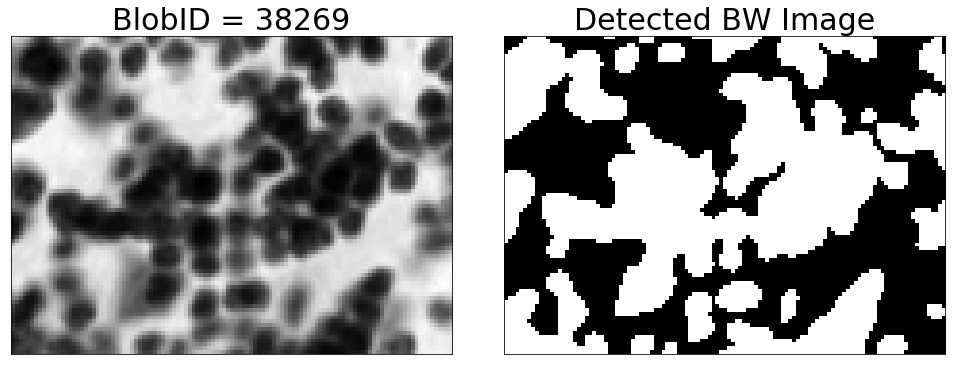

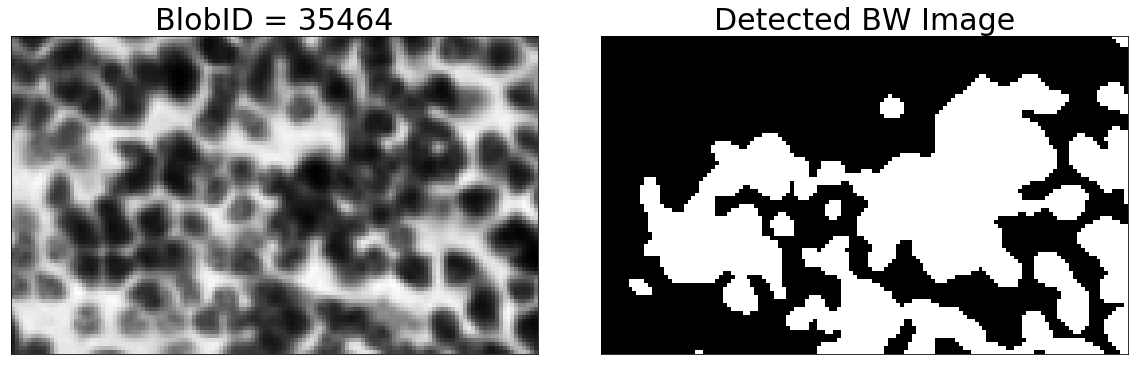

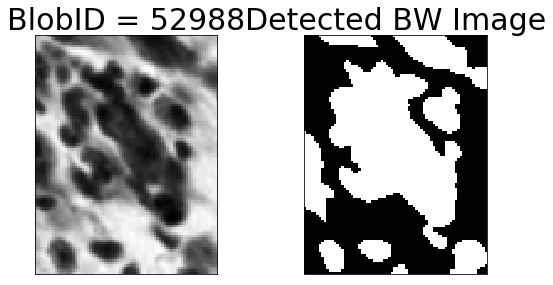

In [52]:
# Visualize large blobs (size between 2000 and 3000 pixels)
# Conclusion: a few of the blobs with size between 2000 and 3000 piexls are single cell. E.g MD589-200-73615 @(9648, 6510)
cell_idx_3000 = np.where(np.logical_and(cell_area_0>2000, cell_area_0<=3000))[0]
margin = 10
for blobID in np.random.choice(cell_idx_3000,10):
    display_images_in_grids([fun_crop_images(im_cropped[secIdx],*im_blob_prop[sec][blobID]['bbox'],margin=margin, im0max=im0max, im1max=im1max),
                            fun_crop_images(im_BW[secIdx],*im_blob_prop[sec][blobID]['bbox'],margin=margin, im0max=im0max, im1max=im1max)]
                            ,nc=2, cmap=plt.cm.gray,titles=['BlobID = %d'%blobID, 'Detected BW Image'])

(array([  8041.,  18515.,  14096.,   7913.,   5428.,   4316.,   3708.,
          3215.,   2667.,   2127.,   1751.,   1523.,   1264.,   1147.,
           913.,    847.,    697.,    614.,    507.,    440.,    376.,
           292.,    272.,    253.,    227.]),
 array([   0.,   20.,   40.,   60.,   80.,  100.,  120.,  140.,  160.,
         180.,  200.,  220.,  240.,  260.,  280.,  300.,  320.,  340.,
         360.,  380.,  400.,  420.,  440.,  460.,  480.,  500.]),
 <a list of 25 Patch objects>)

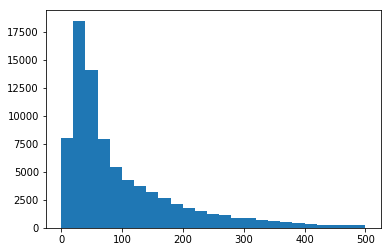

In [74]:
# Statistics of blob size between 0 and 500
cell_idx_500 = np.where(np.logical_and(cell_area_0>0, cell_area_0<=500))[0]
cell_area_500 = np.array([im_blob_prop[sec][blobID]['area'] for blobID in cell_idx_500])
plt.hist(cell_area_500,bins=25,range=(0,500))
# plt.yscale('log')

